In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [42]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)


TRAIN_DIR = 'C:/Users/SoumyadipGhosh/Downloads/Car-Classification-master/dataset'
image_data = image_generator.flow_from_directory(TRAIN_DIR,
                                                shuffle=True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH))
                                                     


Found 462 images belonging to 3 classes.


In [43]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)


In [35]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [44]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}
#This helps for transfer learning. The model is called Headless model as tensorflow does not provide the 
#the upper classification layers.

In [47]:
import tensorflow_hub as hub
#Creating the feature extractor.. imbibing the model without the top layers
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [48]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [49]:
feature_extractor_layer.trainable = False

In [52]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  keras.layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [53]:
predictions = model(image_batch)

In [54]:
predictions.shape

TensorShape([32, 3])

In [55]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [56]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [58]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=5,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/5
15/15 [==============================] - ETA: 6:18 - loss: 1.5877 - acc: 0.125 - ETA: 3:38 - loss: 1.3955 - acc: 0.343 - ETA: 2:38 - loss: 1.3032 - acc: 0.468 - ETA: 2:06 - loss: 1.2364 - acc: 0.500 - ETA: 1:45 - loss: 1.1519 - acc: 0.687 - ETA: 1:28 - loss: 1.1069 - acc: 0.531 - ETA: 1:18 - loss: 1.0572 - acc: 0.642 - ETA: 1:05 - loss: 1.0234 - acc: 0.562 - ETA: 53s - loss: 1.0214 - acc: 0.562 - ETA: 43s - loss: 1.0132 - acc: 0.50 - ETA: 34s - loss: 1.0109 - acc: 0.62 - ETA: 25s - loss: 0.9879 - acc: 0.65 - ETA: 16s - loss: 0.9606 - acc: 0.65 - ETA: 8s - loss: 0.9445 - acc: 0.6562 - 120s 8s/step - loss: 0.9249 - acc: 0.5312
Epoch 2/5
15/15 [==============================] - ETA: 1:26 - loss: 0.5508 - acc: 0.718 - ETA: 1:20 - loss: 0.6387 - acc: 0.718 - ETA: 1:13 - loss: 0.6887 - acc: 0.625 - ETA: 1:06 - loss: 0.6995 - acc: 0.593 - ETA: 1:00 - loss: 0.7392 - acc: 0.531 - ETA: 54s - loss: 0.7643 - acc: 0.718 - ETA: 44s - loss: 0.7215 - acc: 0.78 - ETA: 39s - loss: 0.7213 - acc

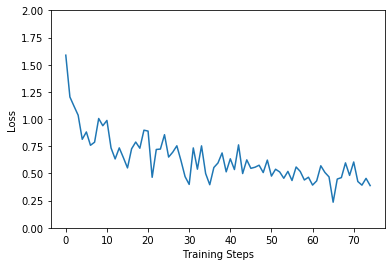

In [59]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

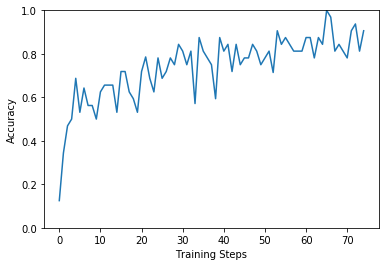

In [60]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [61]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Honda', 'Hyundai', 'Mercedes'], dtype='<U8')

In [62]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [63]:
label_id = np.argmax(label_batch, axis=-1)

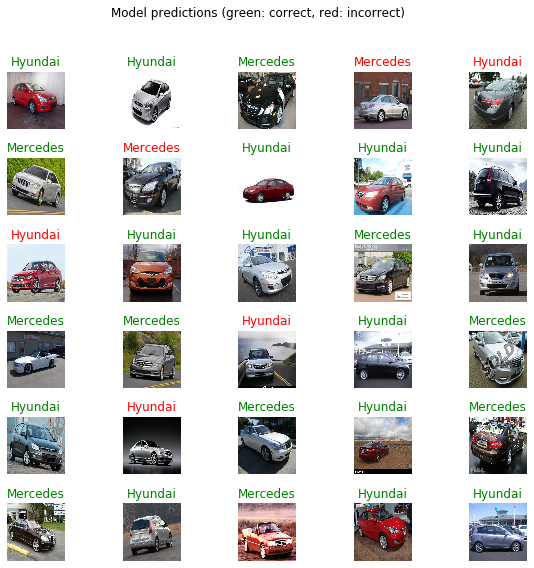

In [64]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
